In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
%reload_ext autoreload

In [2]:
import sys
sys.path.append('../src')
from satellite_image import SatelliteImage
from utils import *
from plot_utils import *
from mappings import *
from labeler import RIL_BDTOPOLabeler
from labeled_satellite_image import SegmentationLabeledSatelliteImage

In [4]:
import s3fs
import matplotlib.pyplot as plt
import re

In [6]:
update_storage_access()

environment = get_environment()

root_path = get_root_path()

bucket = environment["bucket"]

path_s3_pleiades_data_2022_guyane = environment["sources"]["PLEIADES"][2022]["guyane"]
path_local_pleiades_data_2022_guyane = environment["local-path"]["PLEIADES"][2022]["guyane"]

path_local_bdtopo_data = environment["local-path"]["BDTOPO"][2022]["guyane"]
path_s3_bdtopo_data = environment["sources"]["BDTOPO"][2022]["guyane"]

fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})



In [ ]:
fs.download(
        rpath=f"{bucket}/{path_s3_pleiades_data_2022_guyane}",
        lpath=f"../{path_local_pleiades_data_2022_guyane}",
        recursive=True)

fs.download(
        rpath=f"{bucket}/{path_s3_bdtopo_data}",
        lpath=f"../{path_local_bdtopo_data}",
        recursive=True
)

In [9]:
filename = '../data/PLEIADES/2022/GUYANE/ORT_2022072050325085_0353_0545_U22N_16Bits.jp2'
date = datetime.strptime(re.search(r'ORT_(\d{8})', filename).group(1), '%Y%m%d')

In [10]:
image = SatelliteImage.from_raster(
        filename,
        date = date, 
        n_bands = 4,
        dep = '973'
    )
image.normalize()

In [ ]:
labeler_RIL_BDTOPO = RIL_BDTOPOLabeler(date, '973')

In [ ]:
mask_RIL_BDTOPO = labeler_RIL_BDTOPO.create_segmentation_label(image)

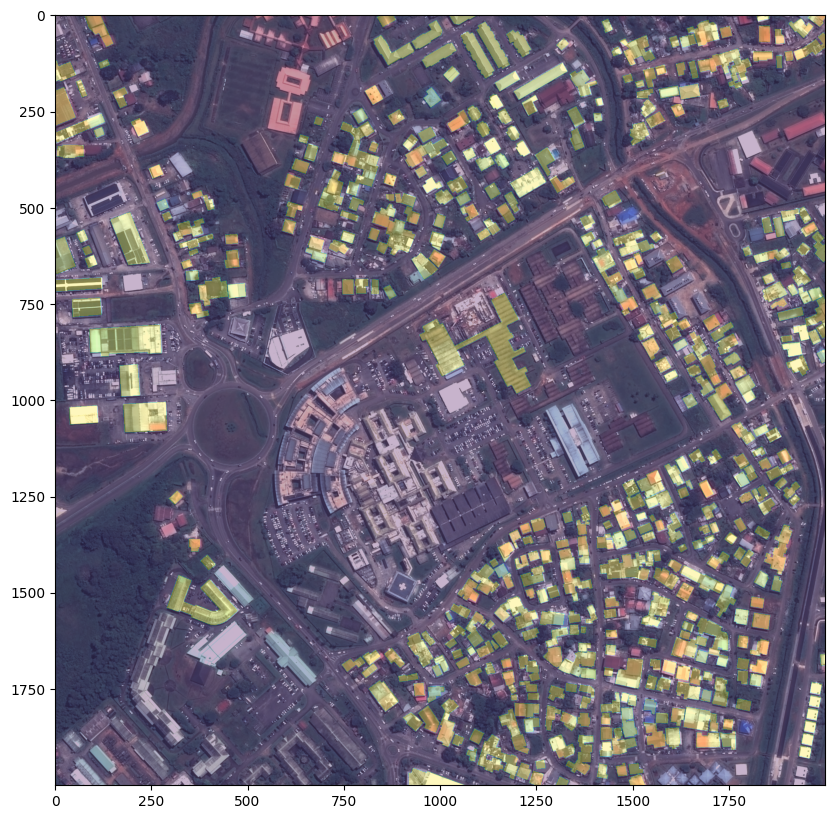

In [25]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(np.transpose(image.array, (1, 2, 0))[:,:,:3])
ax.imshow(mask_RIL_BDTOPO, alpha=0.3)